#Importação das Bibliotecas
Carrega bibliotecas que são ferramentas de trabalho para:

- Manipular dados (pandas, numpy)

- Fazer gráficos (matplotlib, seaborn)

- Construir modelos de machine learning (sklearn)

Bibliotecas específicas serão importandas ao longo do script

In [69]:
import os
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from collections import Counter
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, brier_score_loss, log_loss, balanced_accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    log_loss, brier_score_loss, classification_report
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier, Pool

# Coleta de Dados
Vamos fazer o download da base de dados e armazená-la em um DataFrame.

In [70]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'student-depression-dataset' dataset.
Path to dataset files: /kaggle/input/student-depression-dataset


In [71]:
# Lista todos os arquivos e diretórios baixados
dataset_name = os.listdir(path)[0]
print(os.listdir(path))

['student_depression_dataset.csv']


##Criar o DataFrame

In [72]:
# Criação do dataframe
df_dataset = pd.read_csv(os.path.join(path, dataset_name))

#Análise Exploratória dos Dados - 1a Parte
Esta primeira análise exploratória tem por objetivo conhecer os dados brutos e verificar a necessidade de transformações.

##Tipo dos Dados

In [73]:
print(df_dataset.dtypes)

id                                         int64
Gender                                    object
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                          object
Family History of Mental Illness          object
Depression                                 int64
dtype: object


## Estatística	Descritiva
A análise descritiva é a primeira etapa da análise de dados, e tem como objetivo resumir, organizar e entender as principais características de um conjunto de dados de forma simples e objetiva, sem tirar conclusões causais ou fazer previsões.

* count:	Número de valores não nulos (não NaN)
* mean:	Média aritmética dos valores
* std:	Desvio padrão (medida de dispersão)
* min:	Valor mínimo
* 25%:	Primeiro quartil (Q1) – 25% dos dados estão abaixo desse valor
* 50%:	Mediana (Q2) – metade dos dados estão abaixo desse valor
* 75%:	Terceiro quartil (Q3) – 75% dos dados estão abaixo desse valor
* max:	Valor máximo

In [74]:
pd.options.display.float_format = '{:.2f}'.format
df_whitout_id = df_dataset.drop('id', axis=1)
df_whitout_id.describe()

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Depression
count,27901.00,27901.00,27901.00,27901.00,27901.00,27901.00,27901.00,27901.00
mean,25.82,3.14,0.00,7.66,2.94,0.00,7.16,0.59
std,4.91,1.38,0.04,1.47,1.36,0.04,3.71,0.49
min,18.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,21.00,2.00,0.00,6.29,2.00,0.00,4.00,0.00
50%,25.00,3.00,0.00,7.77,3.00,0.00,8.00,1.00
75%,30.00,4.00,0.00,8.92,4.00,0.00,10.00,1.00
max,59.00,5.00,5.00,10.00,5.00,4.00,12.00,1.00


In [75]:
dep = df_dataset['Depression'].value_counts().reset_index()
dep.columns = ['Depressao', 'Quantidade']
print(dep)

   Depressao  Quantidade
0          1       16336
1          0       11565


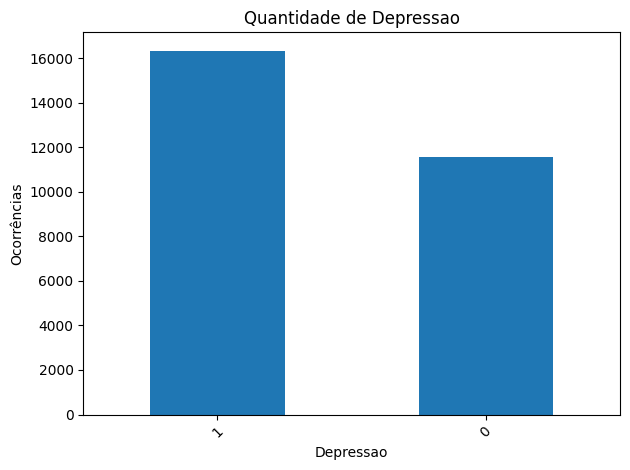

In [76]:
df_dataset['Depression'].value_counts().plot(kind='bar')
plt.title('Quantidade de Depressao')
plt.xlabel('Depressao')
plt.ylabel('Ocorrências')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Total Com Depressão x Sem Depressão

In [77]:
# Total de registros no DataFrame
total_registros = len(df_dataset)

# Soma diagnostico de depressao
total_nao_dep = dep[dep['Depressao'] == 0]['Quantidade'].sum()

# Soma apenas as dep (exclui no depressao(0))
total_dep = dep[dep['Depressao'] != 0]['Quantidade'].sum()

# Calcula a porcentagem
percentual_nao_dep = (total_nao_dep / total_registros) * 100
percentual_dep = (total_dep / total_registros) * 100

# Exibe o resultado
print(f"Total de registros.: {total_registros}")
print(f"Total de sem depressao: {total_nao_dep} ou {percentual_nao_dep:.2f}% do total")
print(f"Total de depressao....: {total_dep} ou {percentual_dep:.2f}% do total")


Total de registros.: 27901
Total de sem depressao: 11565 ou 41.45% do total
Total de depressao....: 16336 ou 58.55% do total


#Engenharia de Dados

##Eliminar Valores Nulos
A eliminação de valores nulos deverá ser feita com cuidados. É necessário avaliar a real necessidade de eliminá-los, pois há alternativas, por exemplo, substituir os valores faltantes pela moda ou pela média.

In [78]:
df_dataset.isnull().sum()

,0
id,0
Gender,0
Age,0
City,0
Profession,0
Academic Pressure,0
Work Pressure,0
CGPA,0
Study Satisfaction,0
Job Satisfaction,0


Não há dados nulos

##Eliminar as Linhas Duplicadas
Já sabemos que não há duplicação, então, este passo não seria necessário, mas fica a título de exemplo

# Nova seção

#Cabeçalho com coluna 'Sleep Duration' formatada

Tirar o 'hours' e substituir 'Less than' por '<' e 'More than' por '>'.

In [79]:
sleep_map = {
    "'Less than 5 hours'": 4,
    "'5-6 hours'": 5.5,
    "'7-8 hours'": 7.5,
    "'More than 8 hours'": 9,
     'Others': 0
}
if 'Sleep Duration' in df_dataset.columns:
    df_dataset['Sleep Duration'] = df_dataset['Sleep Duration'].map(sleep_map)

df_dataset.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.00,Visakhapatnam,Student,5.00,0.00,8.97,2.00,0.00,5.50,Healthy,B.Pharm,Yes,3.00,1.0,No,1
1,8,Female,24.00,Bangalore,Student,2.00,0.00,5.90,5.00,0.00,5.50,Moderate,BSc,No,3.00,2.0,Yes,0
2,26,Male,31.00,Srinagar,Student,3.00,0.00,7.03,5.00,0.00,4.00,Healthy,BA,No,9.00,1.0,Yes,0
3,30,Female,28.00,Varanasi,Student,3.00,0.00,5.59,2.00,0.00,7.50,Moderate,BCA,Yes,4.00,5.0,Yes,1
4,32,Female,25.00,Jaipur,Student,4.00,0.00,8.13,3.00,0.00,5.50,Moderate,M.Tech,Yes,1.00,1.0,No,0


#Rodapé com coluna 'Sleep Duration' formatada

Tirar o 'hours' e substituir 'Less than' por '<' e 'More than' por '>'.

In [80]:
df_dataset.tail()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
27896,140685,Female,27.00,Surat,Student,5.00,0.00,5.75,5.00,0.00,5.50,Unhealthy,'Class 12',Yes,7.00,1.0,Yes,0
27897,140686,Male,27.00,Ludhiana,Student,2.00,0.00,9.40,3.00,0.00,4.00,Healthy,MSc,No,0.00,3.0,Yes,0
27898,140689,Male,31.00,Faridabad,Student,3.00,0.00,6.61,4.00,0.00,5.50,Unhealthy,MD,No,12.00,2.0,No,0
27899,140690,Female,18.00,Ludhiana,Student,5.00,0.00,6.88,2.00,0.00,4.00,Healthy,'Class 12',Yes,10.00,5.0,No,1
27900,140699,Male,27.00,Patna,Student,4.00,0.00,9.24,1.00,0.00,4.00,Healthy,BCA,Yes,2.00,3.0,Yes,1


In [81]:
# Quantidade total antes
total_antes = len(df_dataset)

# Quantidade de duplicadas
duplicadas = df_dataset.duplicated().sum()

# Remover duplicadas
df_dataset = df_dataset.drop_duplicates()

# Quantidade total depois
total_depois = len(df_dataset)

print(f"Total de linhas antes......................: {total_antes}")
print(f"Linhas duplicadas detectadas...............: {duplicadas}")
print(f"Total de linhas depois do drop_duplicates(): {total_depois}")

Total de linhas antes......................: 27901
Linhas duplicadas detectadas...............: 0
Total de linhas depois do drop_duplicates(): 27901


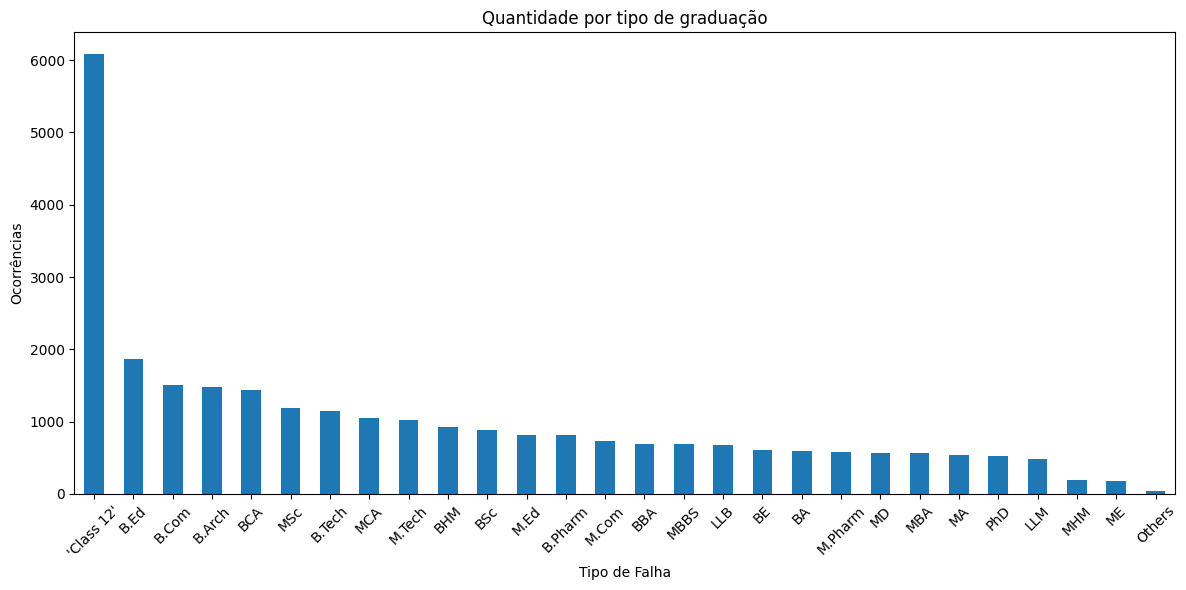

In [82]:
#Exibe um gráfico da quantidade de falhas por 'Failure Code'
plt.figure(figsize=(12, 6))
df_dataset['Degree'].value_counts().plot(kind='bar')
plt.title('Quantidade por tipo de graduação')
plt.xlabel('Tipo de Falha')
plt.ylabel('Ocorrências')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Análise Exploratória dos Dados - 2a Parte
Não há necessidade de repetir os comando da 1a Parte, pois não houve mudança dos dados (nenhum valor nulo, por exemplo). Então, vamos aproveitar para fazer mais análises e gráficos

##Histogramas das Variáveis Numéricas

* O **histograma** (barras) mostra a **frequência** de registros em faixas específicas de temperatura do ar.
* A **linha azul** representa a **curva de densidade estimada** — ela suaviza os dados e mostra como os valores estão concentrados.
* O eixo **X** mostra a temperatura do ar em Kelvin.
* O eixo **Y** mostra quantas amostras estão em cada faixa de temperatura.

### *Interpretação:*

Vamos fazer para o primeiro. Convido você a fazer para os demais.

| Observação                                                      | Significado                                                                       |
| --------------------------------------------------------------- | --------------------------------------------------------------------------------- |
| A maior parte dos dados está entre **297K e 303K**              | Temperaturas de operação típicas ficam nessa faixa (\~24°C a 30°C)                |
| A distribuição tem vários **picos** (multimodal)                | Pode haver grupos de máquinas ou momentos distintos de operação                   |
| Existe uma **simetria moderada**, com leve inclinação à direita | Mostra que há **alguns casos com temperaturas mais altas**, mas sem grande desvio |

### *Relação com falhas:*

Apesar de ser uma variável bem distribuída e aparentemente "estável", sabemos por análises anteriores (como boxplots e pairplots) que:

* **Falhas como Heat Dissipation Failure** tendem a ocorrer quando a temperatura do ar está **acima de 302K**.
* Isso pode ser confirmado visualmente nesse gráfico: a “cauda direita” da curva (temperaturas maiores) é menos frequente, mas **potencialmente crítica**.


### *Resultado:*

Este gráfico mostra como a temperatura do ar varia na nossa base. A maioria das medições está concentrada perto dos 300K (cerca de 27°C), o que parece ser uma condição normal. Mas há alguns casos onde a temperatura é mais alta, e foi justamente nessas faixas que algumas falhas apareceram, como problemas de dissipação de calor.

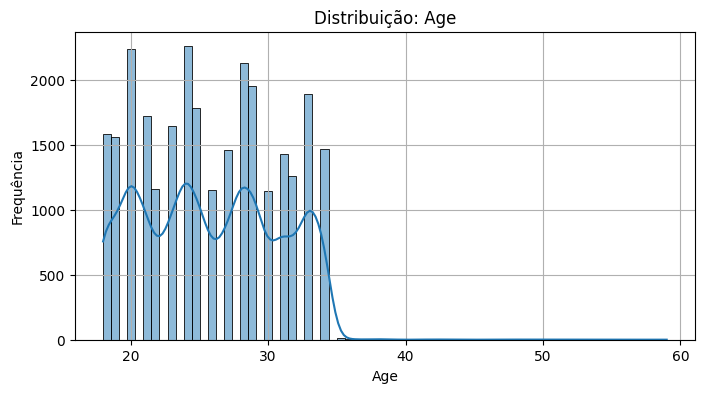

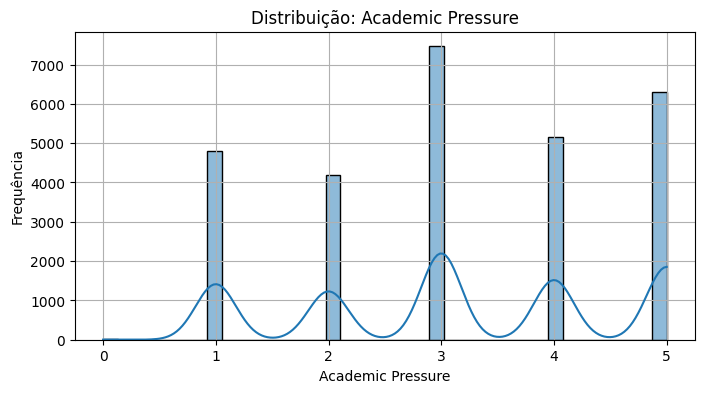

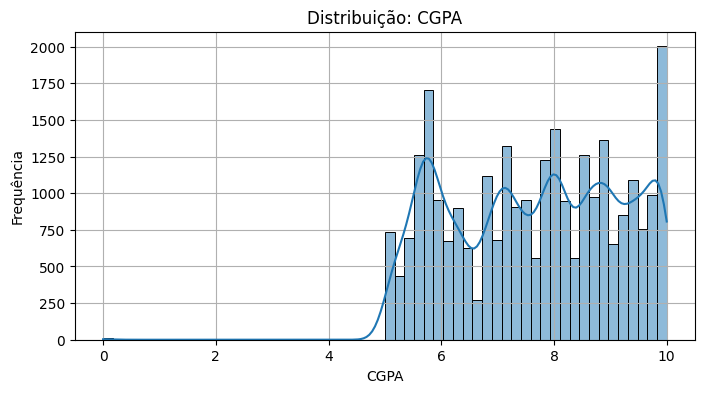

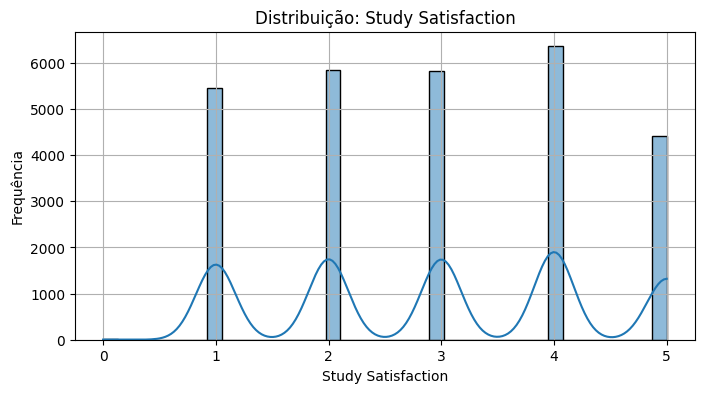

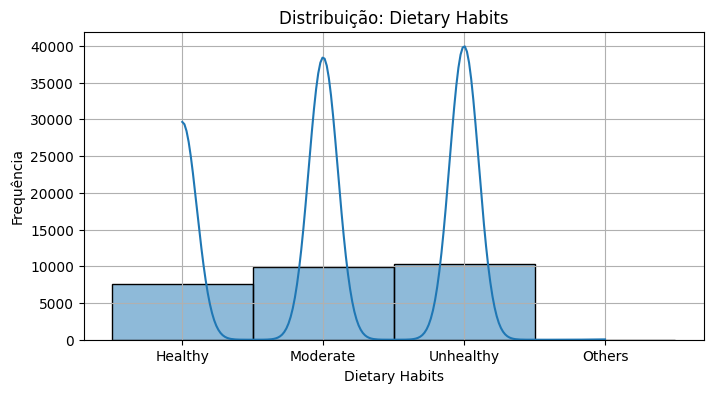

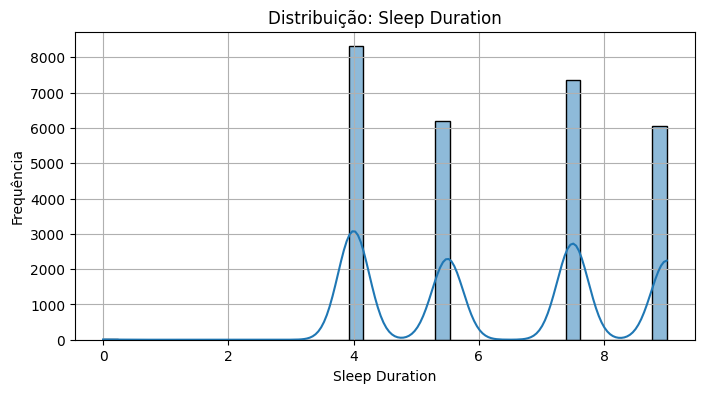

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

variaveis = ['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Dietary Habits', 'Sleep Duration']

for var in variaveis:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_dataset[var], kde=True)
    plt.title(f'Distribuição: {var}')
    plt.xlabel(var)
    plt.ylabel("Frequência")
    plt.grid(True)
    plt.show()


##Pairplot

Esse gráfico compara **todas as variáveis numéricas duas a duas**, usando dispersão (scatterplots) e densidade (diagonal). Ele é segmentado por **tipo de falha (`Failure Type`)**, usando **cores diferentes para cada classe**.

Esse gráfico mostra se há agrupamentos naturais de pontos (falhas) com base em combinações de variáveis. Isso pode mostrar, por exemplo, que falhas de "Power Failure" acontecem com baixa rotação e alto torque.

### *Eixos:*

* Linhas = variável no eixo Y
* Colunas = variável no eixo X
* Diagonal = distribuição (densidade) de cada variável


### *Distribuições diagonais (autocorrelacionadas)*

* As curvas mostram a **distribuição dos valores por variável**.
* Por exemplo, a maioria dos valores de `Torque` está entre **35 e 55 Nm**, mas com **alguns pontos acima de 70** → outliers possivelmente relacionados a falhas.

### *Padrões de falha por cor (fora da diagonal)*

| Variáveis comparadas          | O que se observa?                                                                                       |
| ----------------------------- | ------------------------------------------------------------------------------------------------------- |
| **Air Temp × Process Temp**   | Correlação quase perfeita (esperado fisicamente)                                                        |
| **Torque × Rotational Speed** | Relação inversa clara (quando torque sobe, rotação tende a cair — também esperado)                      |
| **Torque × Failure Type**     | 🔥 Falhas (especialmente Power Failure e Tool Wear Failure) **concentradas em regiões com torque alto** |
| **Tool Wear × Torque/Speed**  | Algumas falhas ocorrem com **desgaste elevado e torque alto**                                           |

### *O que chama atenção?*

* **Power Failure (laranja)** aparece muito mais em regiões com **alta rotação** e **alto torque** → padrão crítico de operação extrema.
* **Tool Wear Failure (verde)** ocorre em regiões de **torque alto + desgaste alto**.
* **Heat Dissipation Failure (roxo)** aparece onde a **temperatura do ar é mais alta**.
* A classe **"No Failure" (azul)** está **muito espalhada**, cobrindo quase todo o gráfico → normal, pois é a classe dominante.

Esse gráfico mostra como as variáveis se comportam em pares e como os diferentes tipos de falha se distribuem nesses espaços. Por exemplo, falhas de desgaste ocorrem quando o torque e o desgaste estão altos. Já falhas de dissipação de calor acontecem quando a temperatura do ar é maior. Esse tipo de visualização nos ajuda a entender que tipo de combinação de condições pode levar a uma falha.


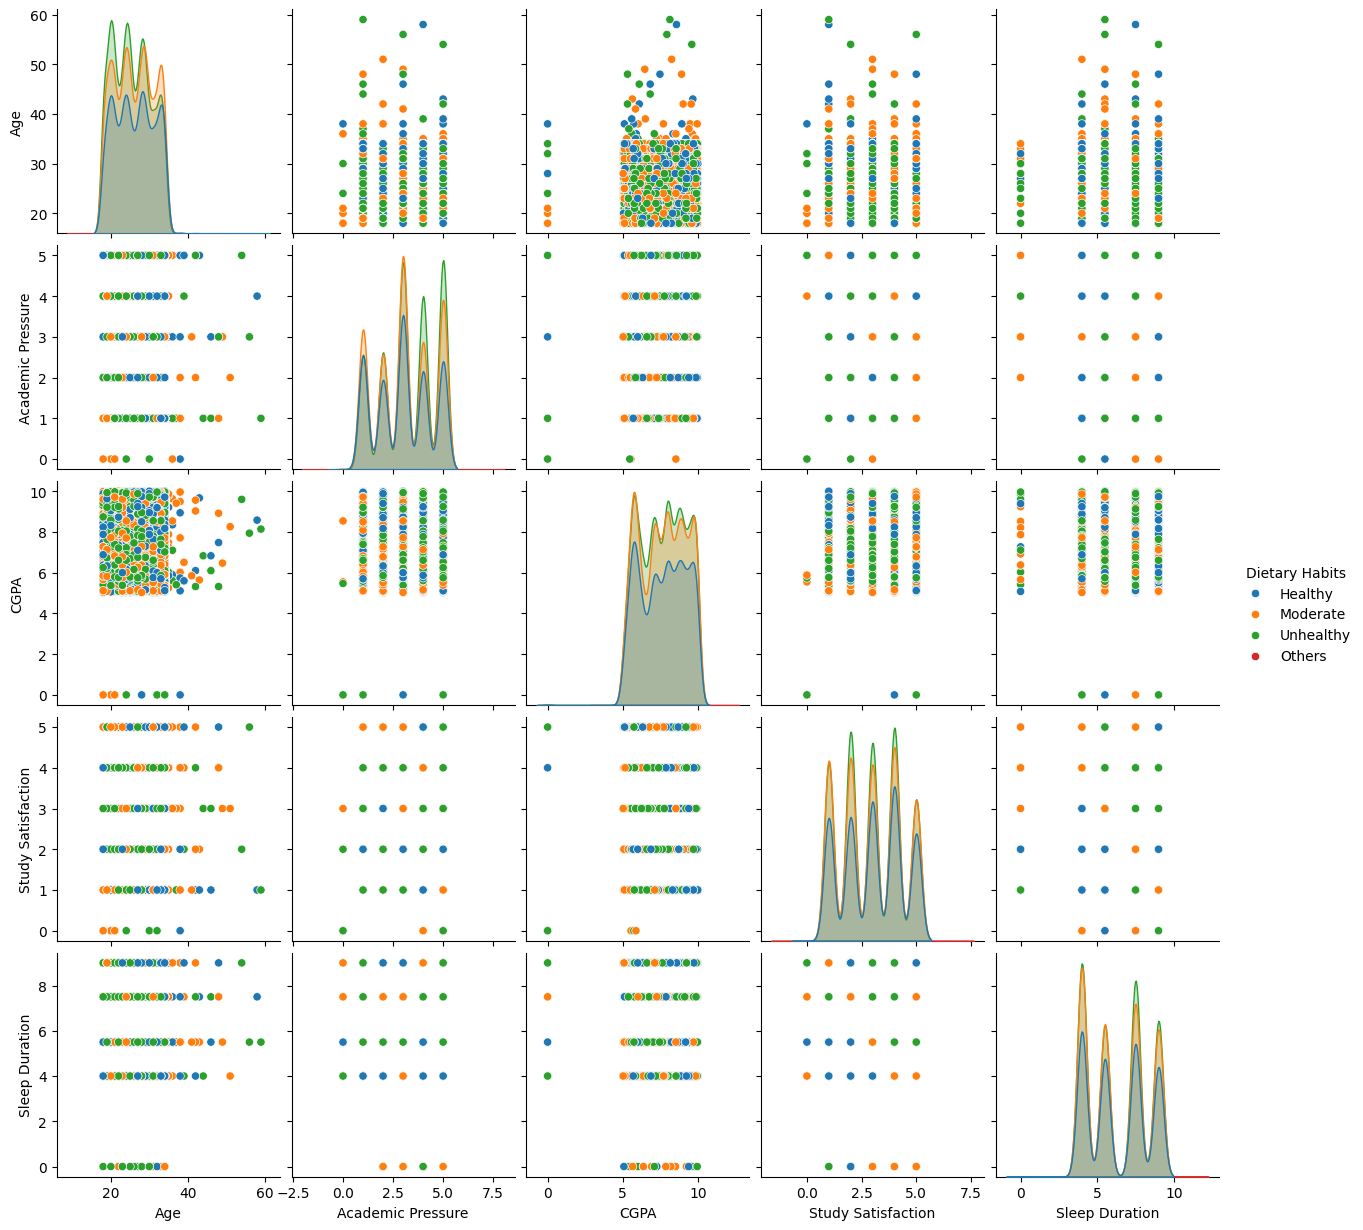

In [84]:
vars_numericas = [c for c in variaveis if pd.api.types.is_numeric_dtype(df_dataset[c])]

sns.pairplot(df_dataset, hue="Dietary Habits", vars=vars_numericas)

##Boxplots

Um boxplot (gráfico de caixa) **resume a distribuição de valores** em cinco partes:

* **Linha central (mediana)**: valor do meio
* **Caixa**: intervalo entre o 1º quartil (25%) e o 3º quartil (75%)
* **“Bigodes” (linhas finas)**: mostram a faixa de valores dentro de 1,5x a amplitude interquartil (IQR)
* **Pontos fora da caixa** (se houver): são considerados **outliers**

### *O que este gráfico mostra?*

Vamos fazer a análise somente para o primeiro gráfico. Convido você a fazer para os demais.

Ele compara a temperatura do ar entre os diferentes **tipos de falha**:

| Tipo de Falha                | Observação sobre Temperatura                                            |
| ---------------------------- | ----------------------------------------------------------------------- |
| **No Failure**               | Mediana \~300K, dispersão normal                                        |
| **Power Failure**            | Similar a “No Failure”, talvez um pouco mais quente                     |
| **Tool Wear Failure**        | Também próximo de 300K, sem destaque claro                              |
| **Overstrain Failure**       | Levemente mais fria que as demais                                       |
| **Random Failures**          | Varia mais, tem uma mediana levemente mais alta                         |
| **Heat Dissipation Failure** | 📌 **Temperatura claramente mais alta** (\~302–304K) e mais concentrada |


### Interpretação prática*

* A temperatura do ar **não varia muito entre os tipos de falha** — a maioria fica em torno de **300 K (\~27 °C)**.
* A exceção é a **Heat Dissipation Failure**, que ocorre com **temperaturas consistentemente mais altas**.

  * Isso faz **sentido físico**, já que o nome indica falha no resfriamento → ar mais quente ao redor do sistema.


### *Resultado*

Este gráfico mostra que, na maioria dos tipos de falha, a temperatura do ar não muda muito. Mas no caso de falha de dissipação de calor, o ar está claramente mais quente. Isso pode indicar que o sistema está retendo calor e não está conseguindo resfriar direito — o que ajuda a entender esse tipo de falha.

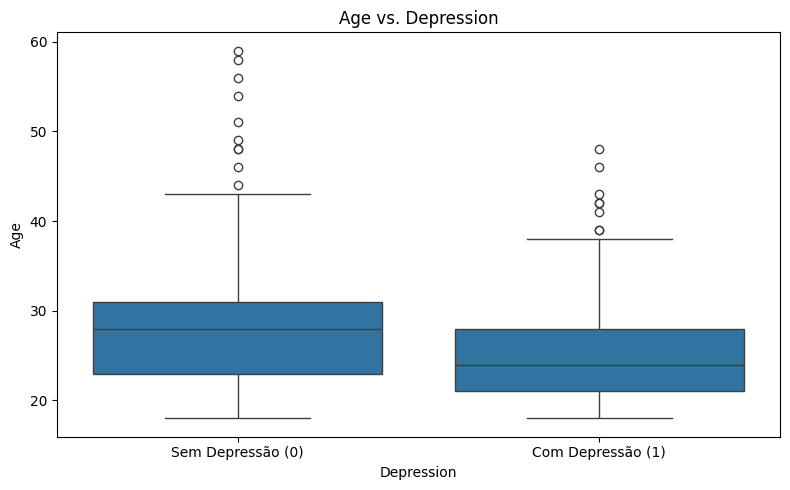

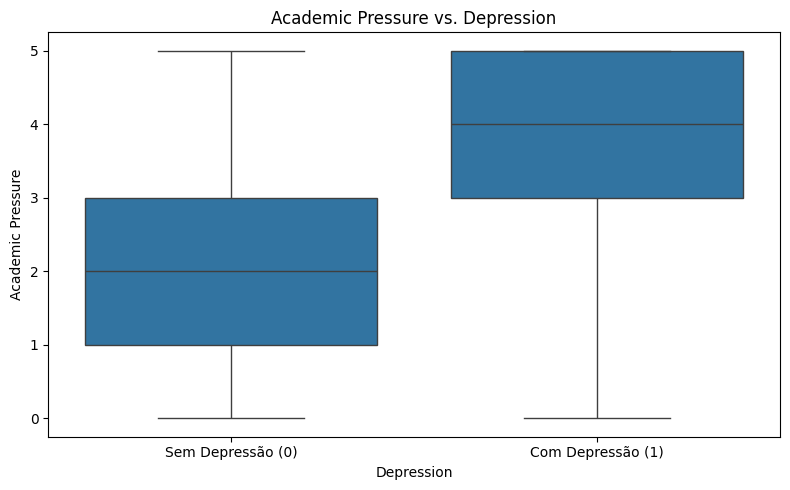

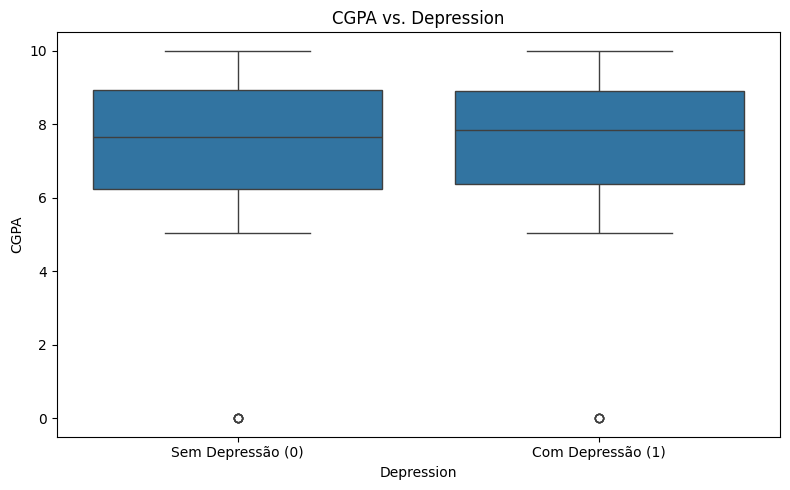

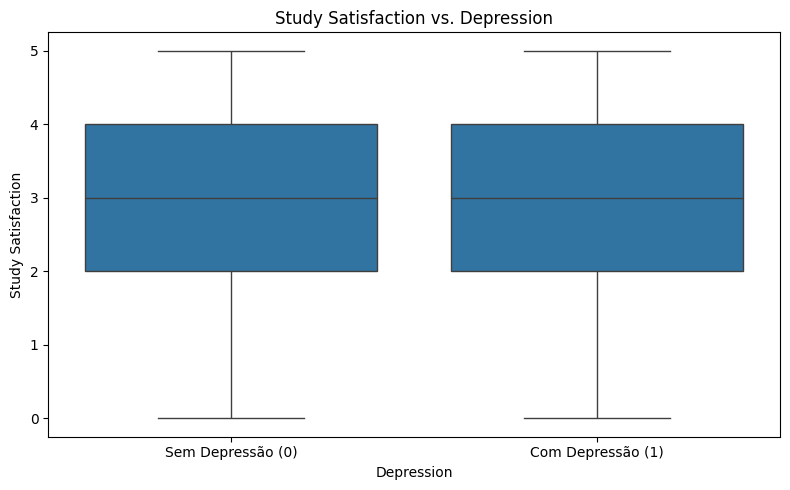

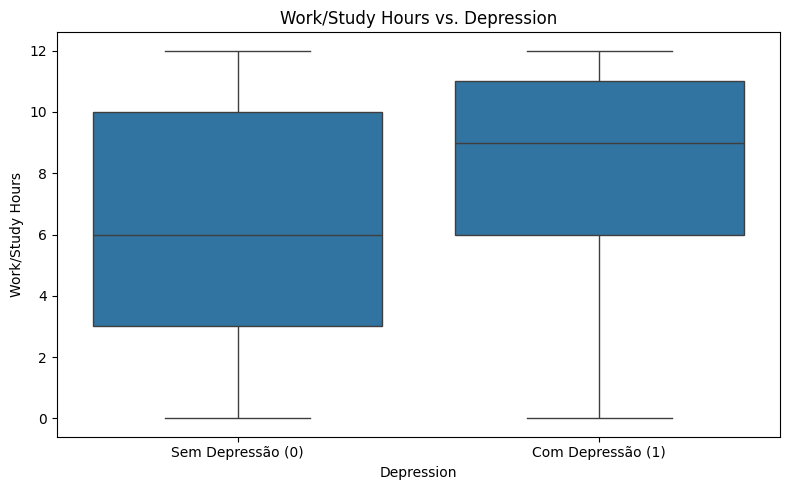

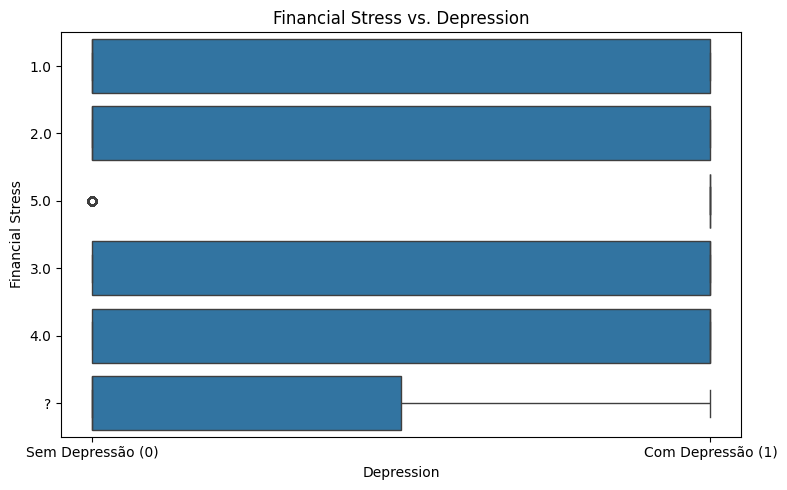

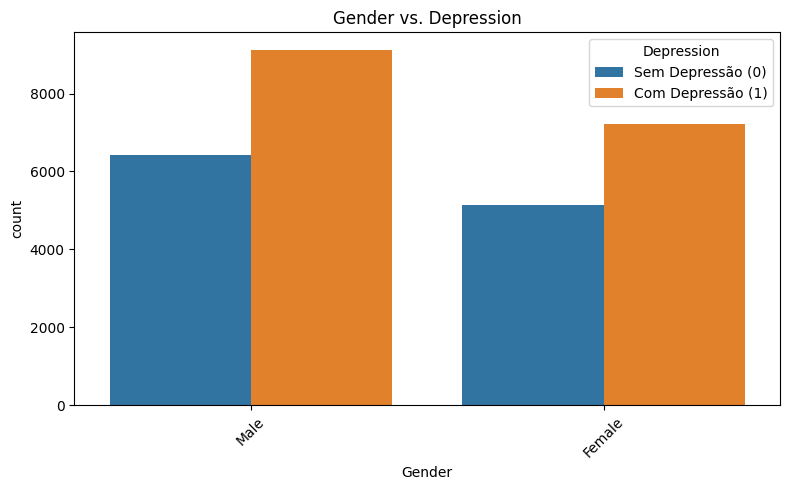

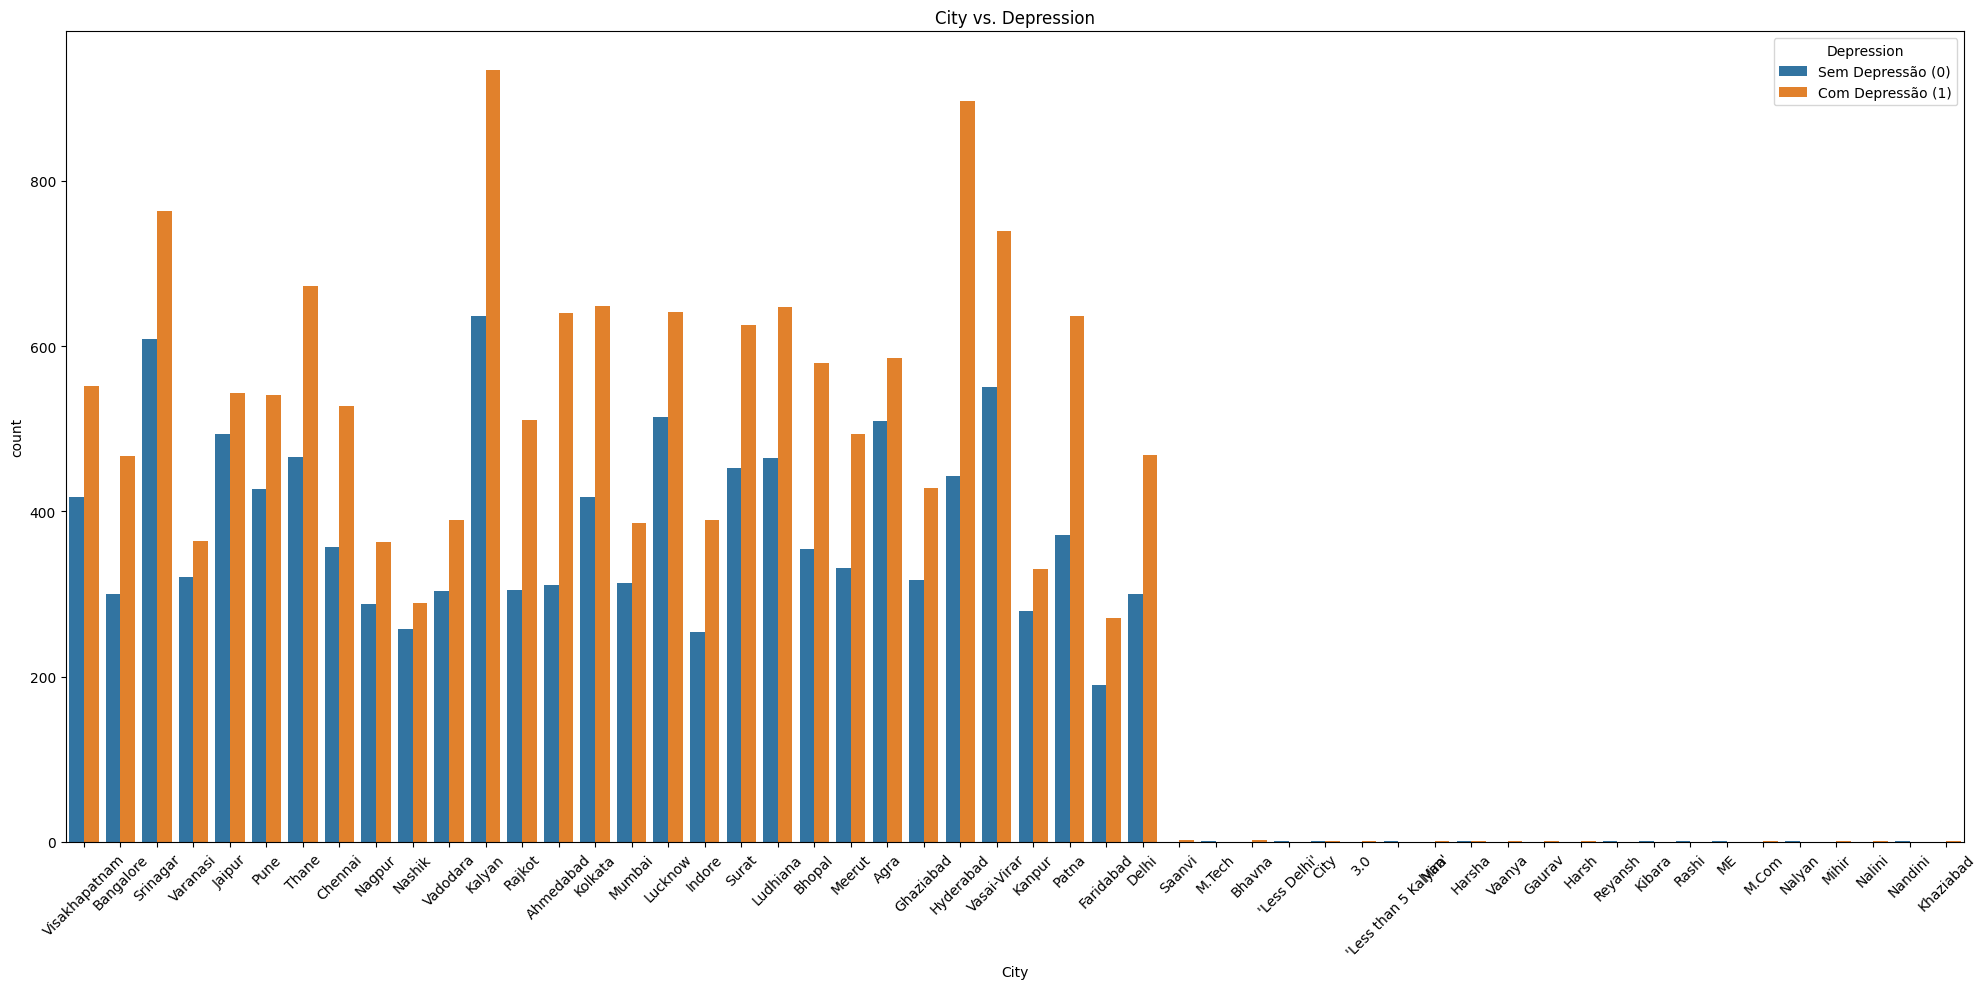

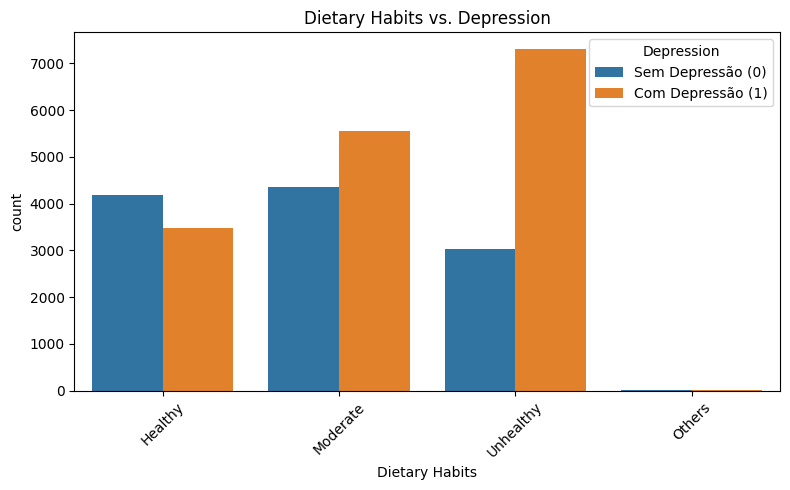

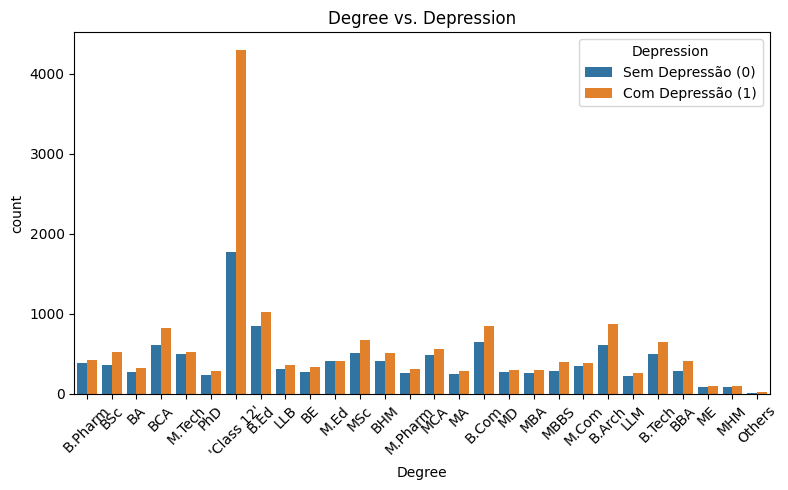

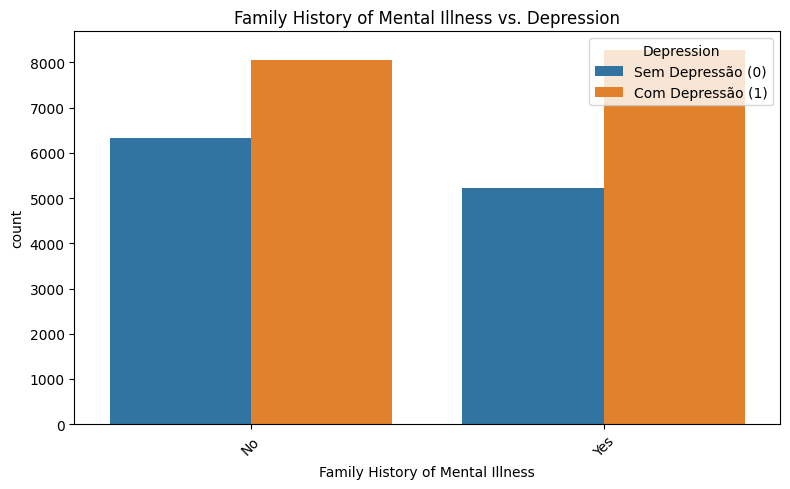

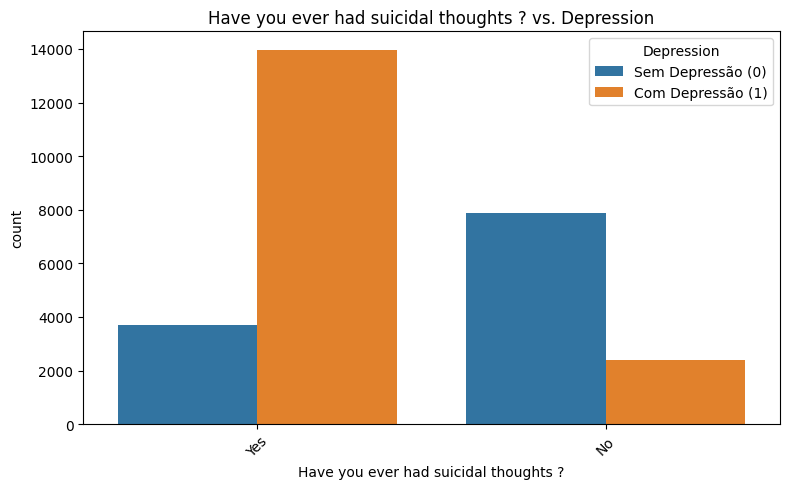

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# BOXPlots - variáveis numéricas
# ===============================
variaveis_numericas = [
    'Age',
    'Academic Pressure',
    'CGPA',
    'Study Satisfaction',
    'Work/Study Hours',
    'Financial Stress'
]

for var in variaveis_numericas:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_dataset, x='Depression', y=var)
    plt.title(f'{var} vs. Depression')
    plt.xticks([0, 1], ['Sem Depressão (0)', 'Com Depressão (1)'])
    plt.tight_layout()
    plt.show()

# bins = [0, 4, 6, 8, 10, 12]
# labels = ['< 5', '5-6', '7-8', '> 8', 'Others']

# # Criar faixas de sono
# df_dataset['SleepRange'] = pd.cut(df_dataset['Sleep Duration'], bins=bins, labels=labels, right=False)
# df_dataset['SleepRange'] = pd.Categorical(df_dataset['SleepRange'], categories=labels, ordered=True)

# # Contar quantas pessoas há em cada faixa, separadas por depressão
# count_df = df_dataset.groupby(['SleepRange', 'Depression']).size().reset_index(name='Count')

# # Gráfico de barras (aqui está a correção)
# plt.figure(figsize=(8,5))
# sns.barplot(data=count_df, x='SleepRange', y='Count', hue='Depression', palette='Set2')

# plt.title('Contagem de Pessoas com/sem Depressão por Faixa de Sono')
# plt.xlabel('Faixa de Horas de Sono')
# plt.ylabel('Quantidade de Pessoas')
# plt.legend(title='Depressão')
# plt.tight_layout()
# plt.show()

# ===============================
# COUNTPLOTS - variáveis categóricas
# ===============================
variaveis_categoricas = [
    'Gender',
    'City',
    'Dietary Habits',
    'Degree',
    'Family History of Mental Illness',
    'Have you ever had suicidal thoughts ?'
]

for var in variaveis_categoricas:

  if var == 'City':
    plt.figure(figsize=(20, 10))
  else:
    plt.figure(figsize=(8, 5))
  sns.countplot(data=df_dataset, x=var, hue='Depression')
  plt.title(f'{var} vs. Depression')
  plt.xticks(rotation=45)
  plt.legend(title="Depression", labels=["Sem Depressão (0)", "Com Depressão (1)"])
  plt.tight_layout()
  plt.show()



## Matriz de Correlação Selecionada (Mapa de Calor)

A **matriz de correlação de Pearson** mede o **grau de relação linear** entre pares de variáveis.

* Valores próximos de **1** = relação linear positiva forte
* Valores próximos de **−1** = relação linear negativa forte
* Valores próximos de **0** = pouca ou nenhuma relação linear


### *Correlações interessantes entre as variáveis*

| Par de variáveis              | Correlação | O que isso diz                                                                                                     |
| ----------------------------- | ---------- | ------------------------------------------------------------------------------------------------------------------ |
| **Air temp ↔ Process temp**   | +0.88      | Andam juntas — provavelmente aumentam ao mesmo tempo                                                               |
| **Torque ↔ Rotational speed** | −0.88      | Relação **fortemente inversa**: quanto mais torque, menor a rotação (ou vice-versa) — isso faz sentido fisicamente |
| **Outros pares**              | ≈ 0        | Pouca relação direta entre outras variáveis                                                                        |

### *Como isso se conecta à árvore de decisão?*

* **Mesmo que a correlação seja baixa**, a árvore **ainda pode usar essas variáveis** para fazer boas divisões — pois a árvore **não depende apenas de relações lineares**.
* Por exemplo:

  * **Torque e Rotational speed** têm correlação negativa forte entre si, mas **podem ser úteis em ramos distintos da árvore**.

### *Resultado*

Este mapa de calor mostra relações entre as variáveis, não com falhas. Em manutenção preditiva, ele revela co-variações e redundâncias (multicolinearidade) e inspira features derivadas. Depois, modelos não lineares (como árvores) capturam padrões e interações que a correlação linear não mostra — lembre: correlação ≠ causalidade.

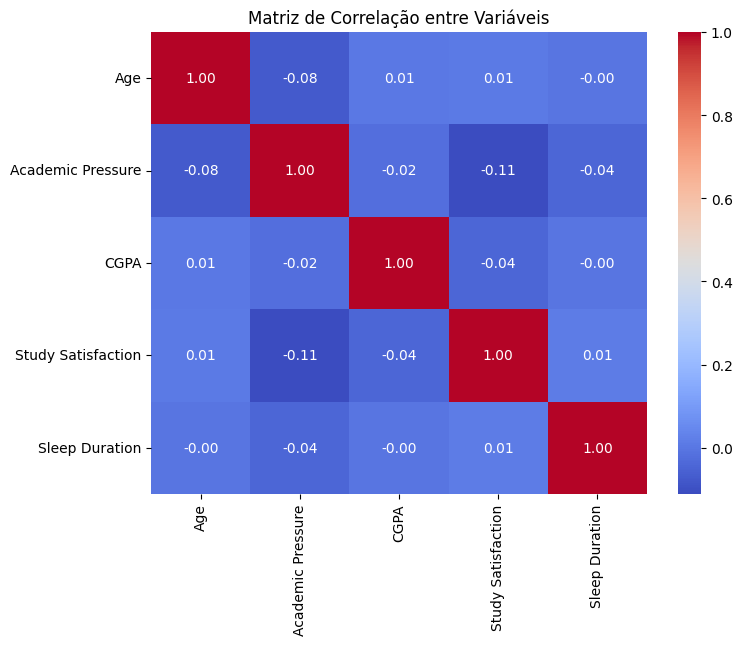

In [86]:
corr_matrix = df_dataset[variaveis].corr(numeric_only=True)

import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis')
plt.show()

##Matriz de Correlação entre as Variáveis e o a Falha

Esse é um **gráfico de barras horizontais** que mostra o **coeficiente de correlação** entre cada variável e o tipo de falha (codificado numericamente).

Mostra a força e direção de uma relação linear entre cada variável e a variável alvo (Failure_Code).

É global e linear: ele verifica se uma variável aumenta ou diminui à medida que o tipo de falha muda (em média).

Valores próximos de zero indicam que a variável isoladamente não tem uma relação linear forte com a falha.

* **Correlação positiva** → conforme o valor da variável aumenta, é mais provável que ocorra um certo tipo de falha (classes maiores).
* **Correlação negativa** → conforme o valor da variável aumenta, a chance de falha diminui ou muda para outro tipo de falha (classes menores).
* **Próximo de zero** → pouca ou nenhuma relação linear direta com o tipo de falha.

### *Interpretação do gráfico*

| Variável                | Correlação com a falha | Interpretação prática                                                                      |
| ----------------------- | ---------------------- | ------------------------------------------------------------------------------------------ |
| **Tool wear \[min]**    | **+0.11**              | Quanto mais desgastada a ferramenta, **maior a chance de falha** (forte indicador).        |
| **Torque \[Nm]**        | +0.03                  | Torque alto está **levemente associado** a tipos de falhas.                                |
| **Rotational speed**    | ≈ 0.00                 | **Praticamente sem correlação linear** com a falha.                                        |
| **Process temperature** | **−0.01**              | Pequena correlação negativa, praticamente irrelevante.                                     |
| **Air temperature**     | **−0.02**              | Um leve indício de que temperaturas mais altas do ar podem estar ligadas a falhas menores. |


### *Como interpretar isso?*

* A única variável com **correlação notável é `Tool wear`**: isso faz sentido, pois ferramentas muito desgastadas tendem a quebrar ou falhar.
* O restante tem **baixa ou nenhuma correlação linear direta**. Isso não significa que são inúteis — apenas que a relação pode ser **não linear** ou **mais complexa**, e por isso é melhor capturada por modelos como árvores.

### *Resultado*

Esse gráfico mostra que, dentre todas as variáveis, o desgaste da ferramenta é o que mais influencia o tipo de falha. Ou seja, quanto mais usada a ferramenta, mais provável que aconteça uma falha grave. Já a rotação ou a temperatura não têm um efeito direto e simples, mas isso não quer dizer que não importam — o modelo pode estar captando interações mais complexas entre elas.


Top pares por |correlação|:
                                      Par  abs_corr
4  Study Satisfaction ↔ Academic Pressure      0.11
0                 Academic Pressure ↔ Age      0.08
5               Study Satisfaction ↔ CGPA      0.04
7      Sleep Duration ↔ Academic Pressure      0.04
2                CGPA ↔ Academic Pressure      0.02
9     Sleep Duration ↔ Study Satisfaction      0.01
3                Study Satisfaction ↔ Age      0.01
1                              CGPA ↔ Age      0.01
8                   Sleep Duration ↔ CGPA      0.00
6                    Sleep Duration ↔ Age      0.00


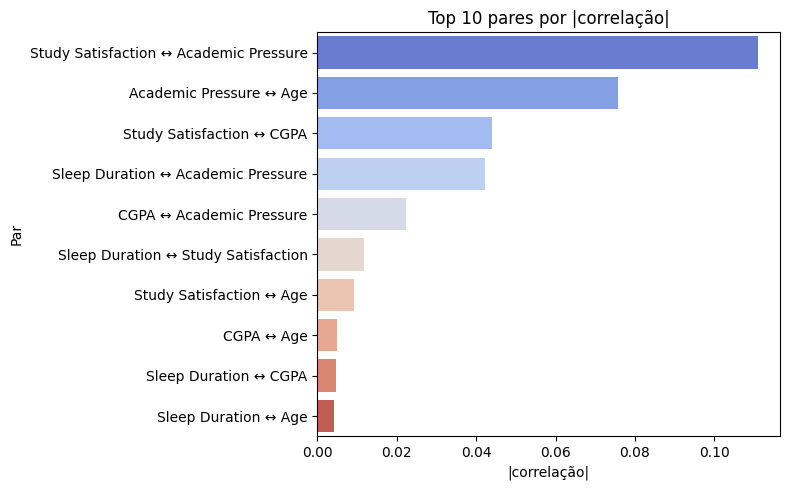

In [87]:
corr = df_dataset[variaveis].corr(numeric_only=True).abs()

mask = np.triu(np.ones_like(corr, dtype=bool))
corr_tri = corr.where(~mask)

pairs = (
    corr_tri.stack()
    .reset_index()
    .rename(columns={'level_0':'Var 1', 'level_1':'Var 2', 0:'abs_corr'})
    .sort_values('abs_corr', ascending=False)
)

top_k = 10
top_pairs = pairs.head(top_k).copy()  # <= evita SettingWithCopyWarning
top_pairs.loc[:, 'Par'] = top_pairs['Var 1'] + ' ↔ ' + top_pairs['Var 2']

print("Top pares por |correlação|:")
print(top_pairs[['Par', 'abs_corr']])

plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_pairs,
    x='abs_corr',
    y='Par',
    hue='Par',          # <= adiciona hue
    legend=False,       # <= remove legenda redundante
    orient='h',
    palette='coolwarm'  # <= agora permitido
)
plt.title(f'Top {top_k} pares por |correlação|')
plt.xlabel('|correlação|')
plt.tight_layout()
plt.show()

# Etapa 3

In [88]:
#Remove lines with invalid variable value
indices_to_drop = df_dataset[df_dataset['Financial Stress'] == '?'].index
#indices_to_drop.append(df_dataset[df_dataset['Sleep Duration'] == 'Others'].index)

indices_to_drop

# Drop the identified rows
df_dropped = df_dataset.drop(indices_to_drop)

diet_map = {
    'Healthy': 3,
    'Moderate': 2,
    'Unhealthy': 1,
    'Others': 0
}

if 'Dietary Habits' in df_dropped.columns:
    df_dropped['Dietary Habits'] = df_dropped['Dietary Habits'].map(diet_map)

binary_map = {
    'Yes': 1,
    'No': 0,
}

gender_map = {
    'Male': 1,
    'Female': 0,
}

if 'Have you ever had suicidal thoughts ?' in df_dropped.columns:
    df_dropped['Have you ever had suicidal thoughts ?'] = df_dropped['Have you ever had suicidal thoughts ?'].map(binary_map)

if 'Family History of Mental Illness' in df_dropped.columns:
    df_dropped['Family History of Mental Illness'] = df_dropped['Family History of Mental Illness'].map(binary_map)

if 'Gender' in df_dropped.columns:
    df_dropped['Gender'] = df_dropped['Gender'].map(gender_map)

    ##Dropar 'Job Satisfaction' , 'Work Pressure'

In [89]:
features = df_dropped[['Age', 'Academic Pressure','Study Satisfaction', 'Sleep Duration', 'Dietary Habits','Have you ever had suicidal thoughts ?','Work/Study Hours','Financial Stress','Family History of Mental Illness']]
target = df_dropped[['Depression']]
print(target)

       Depression
0               1
1               0
2               0
3               1
4               0
...           ...
27896           0
27897           0
27898           0
27899           1
27900           1

[27898 rows x 1 columns]


In [90]:
features.head()

,Age,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,33.00,5.00,2.00,5.50,3,1,3.00,1.0,0
1,24.00,2.00,5.00,5.50,2,0,3.00,2.0,1
2,31.00,3.00,5.00,4.00,3,0,9.00,1.0,1
3,28.00,3.00,2.00,7.50,2,1,4.00,5.0,1
4,25.00,4.00,3.00,5.50,2,1,1.00,1.0,0


Have you ever had suicidal thoughts ?   0.16
Academic Pressure                       0.12
Financial Stress                        0.07
Age                                     0.03
Dietary Habits                          0.02
Work/Study Hours                        0.02
Study Satisfaction                      0.01
Sleep Duration                          0.00
Family History of Mental Illness        0.00
dtype: float64


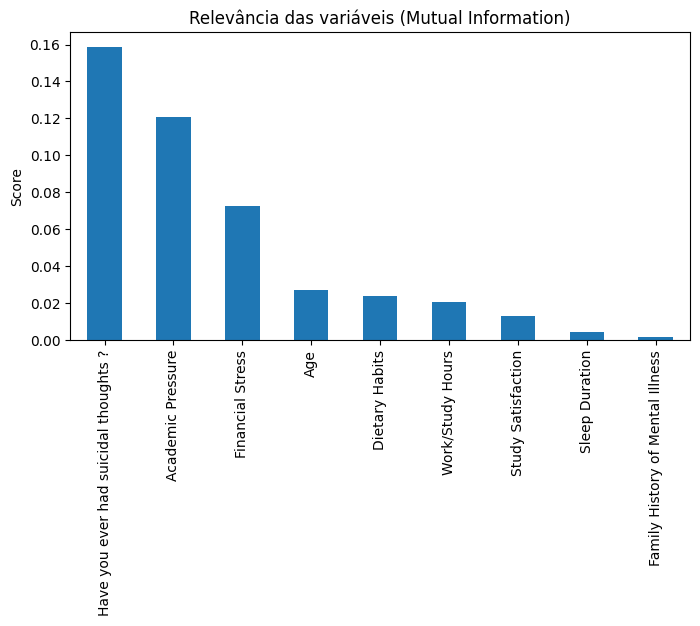

In [91]:
# Calcular mutual information entre cada feature e a classe
mi = mutual_info_classif(features, target.values.ravel(), random_state=42)

mi_series = pd.Series(mi, index=features.columns).sort_values(ascending=False)

# Visualizar
print(mi_series)

# Gráfico de barras
mi_series.plot(kind="bar", figsize=(8,4), title="Relevância das variáveis (Mutual Information)")
plt.ylabel("Score")
plt.show()

In [92]:
X_train, X_test, y_train, y_test = train_test_split(features, target.values.ravel(), test_size=0.2, random_state=42, stratify=target)

X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Contagem simples
print("Distribuição em y_train:")
print(pd.Series(y_train).value_counts())

print("\nDistribuição em y_test:")
print(pd.Series(y_test).value_counts())

# Se quiser formatar mais bonito:
print("\nDistribuição em y_train (percentual):")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nDistribuição em y_test (percentual):")
print(pd.Series(y_test).value_counts(normalize=True))

Distribuição em y_train:
1    13068
0     9250
Name: count, dtype: int64

Distribuição em y_test:
1    3267
0    2313
Name: count, dtype: int64

Distribuição em y_train (percentual):
1   0.59
0   0.41
Name: proportion, dtype: float64

Distribuição em y_test (percentual):
1   0.59
0   0.41
Name: proportion, dtype: float64


#Cria a POOL do CatBoost

In [93]:
cat_cols = features.select_dtypes(include=["object"]).columns.tolist()
cat_idx = [features.columns.get_loc(c) for c in cat_cols]


train_pool = Pool(X_train, y_train, cat_features=cat_idx)
test_pool  = Pool(X_test, y_test, cat_features=cat_idx)
va_pool = Pool(X_va, y_va, cat_features=cat_idx)

print(train_pool)

#Iterar com grid custom para achar as melhores métricas

In [94]:
''' depths = [5, 7, 9]
learning_rates = [0.03, 0.05, 0.087]
iterations_list = [200, 500, 700]
loss_functions = ["Logloss", "MultiClass"]
custom_metric = ["AUC", "Accuracy", "F1", "Recall"]

results = []

for depth in depths:
    for lr in learning_rates:
        for iters in iterations_list:
            for loss_fn in loss_functions:

                print(
                    f"\n============================="
                    f"\nTestando: depth={depth}, lr={lr}, iters={iters}, loss={loss_fn}"
                    f"\n============================="
                )
                model = CatBoostClassifier(
                    depth=depth,
                    learning_rate=lr,
                    iterations=iters,
                    loss_function=loss_fn,
                    eval_metric="AUC",
                    custom_metric=custom_metric,
                    auto_class_weights="Balanced",
                    random_seed=42,
                    verbose=0
                )
                model.fit(
                    train_pool,
                    eval_set=test_pool,
                    use_best_model=True
                )
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)[:, 1]
                report = classification_report(
                    y_test,
                    y_pred,
                    zero_division=0,
                    digits=5
                )
                auc = roc_auc_score(y_test, y_proba)

                print(f"AUC (teste): {auc:.5f}")
                print("\nRelatório de Classificação:\n", report)
                results.append({
                    "depth": depth,
                    "learning_rate": lr,
                    "iterations": iters,
                    "loss_function": loss_fn,
                    "custom_metric": custom_metric,
                    "auc_test": auc,
                    "report": report
                })
best_run = max(results, key=lambda x: x["auc_test"])

print("\n\n===== MELHOR COMBINAÇÃO ENCONTRADA =====")
print(f"depth        : {best_run['depth']}")
print(f"learning_rate: {best_run['learning_rate']}")
print(f"iterations   : {best_run['iterations']}")
print(f"loss_function: {best_run['loss_function']}")
print(f"custom_metric: {best_run['custom_metric']}")
print(f"AUC (teste)  : {best_run['auc_test']:.5f}")

print("\nRelatório de Classificação da melhor combinação:\n")
print(best_run["report"]) '''

' depths = [5, 7, 9]\nlearning_rates = [0.03, 0.05, 0.087]\niterations_list = [200, 500, 700]\nloss_functions = ["Logloss", "MultiClass"]\ncustom_metric = ["AUC", "Accuracy", "F1", "Recall"]\n\nresults = []\n\nfor depth in depths:\n    for lr in learning_rates:\n        for iters in iterations_list:\n            for loss_fn in loss_functions:\n\n                print(\n                    f"\n============================="\n                    f"\nTestando: depth={depth}, lr={lr}, iters={iters}, loss={loss_fn}"\n                    f"\n============================="\n                )\n                model = CatBoostClassifier(\n                    depth=depth,\n                    learning_rate=lr,\n                    iterations=iters,\n                    loss_function=loss_fn,\n                    eval_metric="AUC",\n                    custom_metric=custom_metric,\n                    auto_class_weights="Balanced",\n                    random_seed=42,\n                    verbose

#Definir melhor modelo

In [95]:
''' best_model = CatBoostClassifier(
  depth=best_run['depth'],
  learning_rate=best_run['learning_rate'],
  iterations=best_run['iterations'],
  loss_function=best_run['loss_function'],
  eval_metric="AUC",
  custom_metric=custom_metric,
  auto_class_weights="Balanced",
  random_seed=42,
  verbose=0
) '''

model = CatBoostClassifier()

In [96]:
''' best_model.fit(
  train_pool,
  eval_set=test_pool,
  use_best_model=True
) '''

model.fit(
  train_pool,
  eval_set=test_pool,
  use_best_model=True
)


Learning rate set to 0.068238
0:	learn: 0.6428304	test: 0.6434114	best: 0.6434114 (0)	total: 50.7ms	remaining: 50.6s
1:	learn: 0.5993222	test: 0.6003925	best: 0.6003925 (1)	total: 88.8ms	remaining: 44.3s
2:	learn: 0.5647606	test: 0.5658668	best: 0.5658668 (2)	total: 122ms	remaining: 40.6s
3:	learn: 0.5374878	test: 0.5386516	best: 0.5386516 (3)	total: 146ms	remaining: 36.3s
4:	learn: 0.5115875	test: 0.5128687	best: 0.5128687 (4)	total: 171ms	remaining: 34s
5:	learn: 0.4902067	test: 0.4921872	best: 0.4921872 (5)	total: 195ms	remaining: 32.4s
6:	learn: 0.4732059	test: 0.4756936	best: 0.4756936 (6)	total: 216ms	remaining: 30.7s
7:	learn: 0.4573796	test: 0.4601197	best: 0.4601197 (7)	total: 239ms	remaining: 29.7s
8:	learn: 0.4439307	test: 0.4471791	best: 0.4471791 (8)	total: 260ms	remaining: 28.6s
9:	learn: 0.4330425	test: 0.4364701	best: 0.4364701 (9)	total: 283ms	remaining: 28.1s
10:	learn: 0.4233920	test: 0.4273641	best: 0.4273641 (10)	total: 306ms	remaining: 27.5s
11:	learn: 0.4149193	t

In [97]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [98]:
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred, zero_division=0, digits=5))


Relatório de Classificação:
               precision    recall  f1-score   support

           0    0.83333   0.78902   0.81057      2313
           1    0.85605   0.88828   0.87186      3267

    accuracy                        0.84713      5580
   macro avg    0.84469   0.83865   0.84122      5580
weighted avg    0.84663   0.84713   0.84646      5580



# Treinamento

In [99]:
# Retorna o rótulo previsto para cada amostra (ex.: 0, 1, 2, 3, 4, 5).
proba = model.predict_proba(test_pool)[:, 1]
print(proba)

[0.93868664 0.94102196 0.00457511 ... 0.05231496 0.9582228  0.60466044]


In [100]:
# Retorna as probabilidades por classe para cada amostra.
pred = model.predict(test_pool)
print(pred)

[1 1 0 ... 0 1 1]


#Comparação SMOTE X BASE

In [101]:
sm = SMOTE(random_state=42)
X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)
model_sm = CatBoostClassifier()
model_sm.fit(X_tr_sm, y_tr_sm)
y_pred_sm = model_sm.predict(X_test)
print(classification_report(y_test, y_pred_sm, digits=3))

Learning rate set to 0.041504
0:	learn: 0.6587476	total: 9.88ms	remaining: 9.87s
1:	learn: 0.6306335	total: 22.1ms	remaining: 11s
2:	learn: 0.6049947	total: 33.5ms	remaining: 11.1s
3:	learn: 0.5811380	total: 44.8ms	remaining: 11.2s
4:	learn: 0.5594381	total: 56.9ms	remaining: 11.3s
5:	learn: 0.5405316	total: 78.7ms	remaining: 13s
6:	learn: 0.5230875	total: 88.3ms	remaining: 12.5s
7:	learn: 0.5069662	total: 96.9ms	remaining: 12s
8:	learn: 0.4928610	total: 106ms	remaining: 11.7s
9:	learn: 0.4806421	total: 115ms	remaining: 11.4s
10:	learn: 0.4688239	total: 124ms	remaining: 11.1s
11:	learn: 0.4583723	total: 133ms	remaining: 11s
12:	learn: 0.4488958	total: 143ms	remaining: 10.8s
13:	learn: 0.4396117	total: 152ms	remaining: 10.7s
14:	learn: 0.4316482	total: 162ms	remaining: 10.6s
15:	learn: 0.4256990	total: 171ms	remaining: 10.5s
16:	learn: 0.4186454	total: 180ms	remaining: 10.4s
17:	learn: 0.4126523	total: 190ms	remaining: 10.3s
18:	learn: 0.4070763	total: 203ms	remaining: 10.5s
19:	learn: 

In [102]:
print("Balanced Acc (Base) :", balanced_accuracy_score(y_test, pred))
print("Balanced Acc (SMOTE):", balanced_accuracy_score(y_test, y_pred_sm))

Balanced Acc (Base) : 0.8386476485167678
Balanced Acc (SMOTE): 0.8355063427578461


#Curvas de calibração
Verifica se as probabilidades podem ser usadas como “grau de confiança” (importante para tomar decisão baseada em risco).

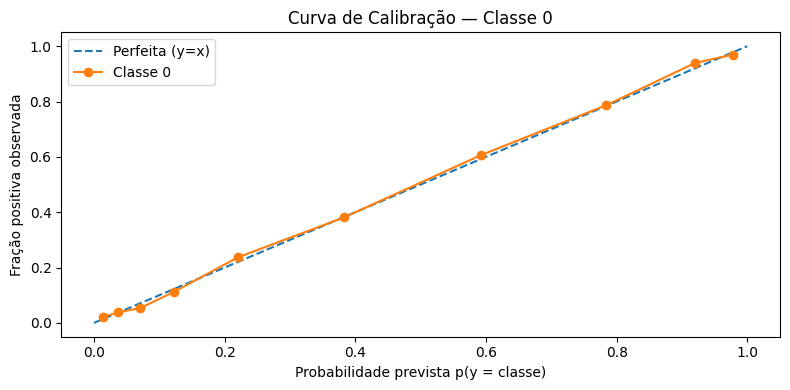

Brier score (classe 0): 0.1106


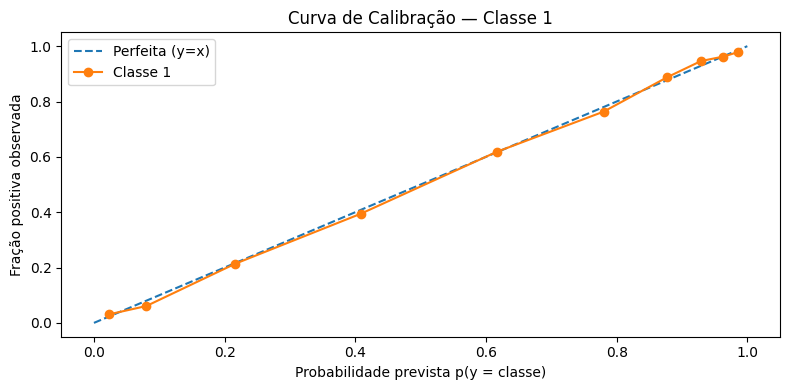

Brier score (classe 1): 0.1106


In [103]:
y_proba = model.predict_proba(X_test)
classes = model.classes_

# Padronização do n_bins = 10
N_BINS = 10

# Uma curva por classe (one-vs-rest)
for k, cls in enumerate(classes):
    y_true_bin = (y_test == cls).astype(int)
    frac_pos, mean_pred = calibration_curve(y_true_bin, y_proba[:, k], n_bins=N_BINS, strategy="quantile")

    plt.figure(figsize=(8,4))
    plt.plot([0,1], [0,1], "--", label="Perfeita (y=x)")
    plt.plot(mean_pred, frac_pos, marker="o", label=f"Classe {cls}")
    plt.xlabel("Probabilidade prevista p(y = classe)")
    plt.ylabel("Fração positiva observada")
    plt.title(f"Curva de Calibração — Classe {cls}")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    # Métrica quantitativa de calibração (Brier score) para a classe k
    bs = brier_score_loss(y_true_bin, y_proba[:, k])
    print(f"Brier score (classe {cls}): {bs:.4f}")

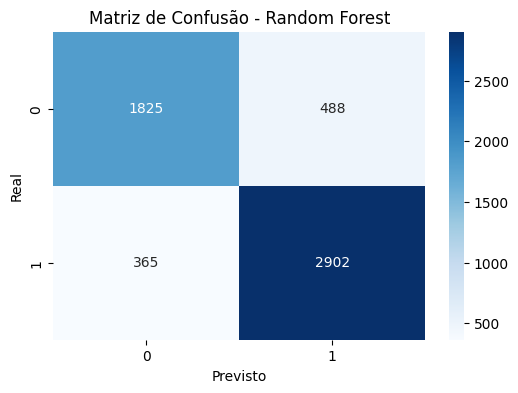

In [104]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

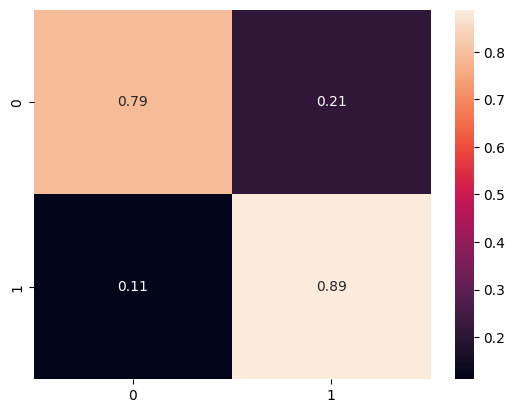

In [105]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f'); plt.show()

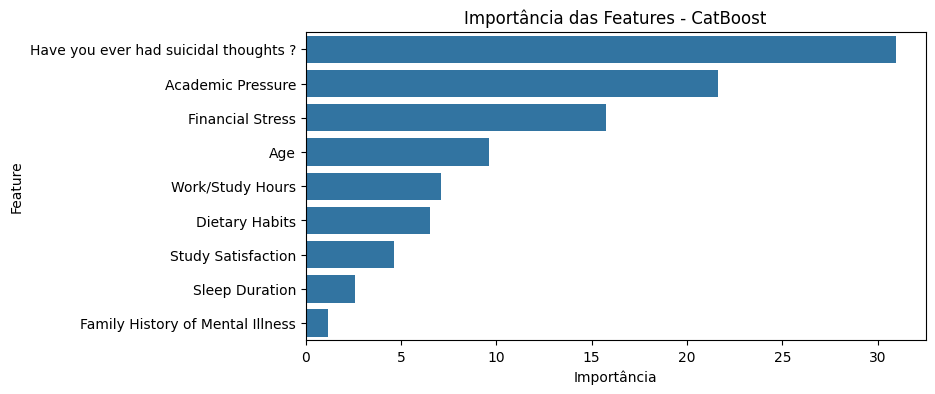

In [106]:
importancias = model.feature_importances_
feature_names = features.columns
importancia_df = pd.DataFrame({'Feature': feature_names, 'Importância': importancias})
importancia_df = importancia_df.sort_values(by='Importância', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(data=importancia_df, x='Importância', y='Feature')
plt.title('Importância das Features - CatBoost')
plt.show()

Have you ever had suicidal thoughts ?    0.11
Academic Pressure                        0.09
Financial Stress                         0.04
Age                                      0.02
Work/Study Hours                         0.01
Dietary Habits                           0.01
Study Satisfaction                       0.01
Sleep Duration                           0.00
Family History of Mental Illness        -0.00
dtype: float64


<Axes: title={'center': 'Permutation Importance'}>

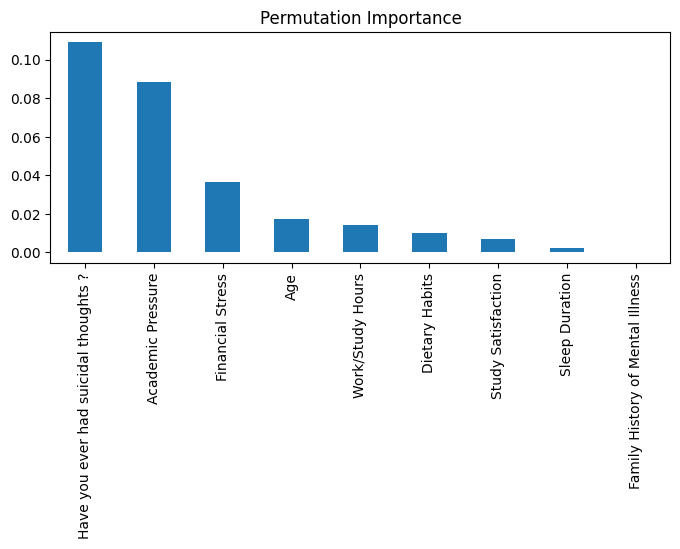

In [107]:
# No conjunto de teste (para não superestimar)
result = permutation_importance(model, X_test, y_test, scoring="f1_macro",
                                n_repeats=20, random_state=42, n_jobs=-1)

importances = pd.Series(result.importances_mean, index=features.columns)
importances = importances.sort_values(ascending=False)

print(importances)

# Gráfico
importances.plot(kind="bar", figsize=(8,3), title="Permutation Importance")


=== Permutation Importance focada na classe 1 (F1-binário) ===


,0
Have you ever had suicidal thoughts ?,0.09
Academic Pressure,0.07
Financial Stress,0.03
Age,0.01
Work/Study Hours,0.01
Dietary Habits,0.01
Study Satisfaction,0.01
Sleep Duration,0.00
Family History of Mental Illness,0.00


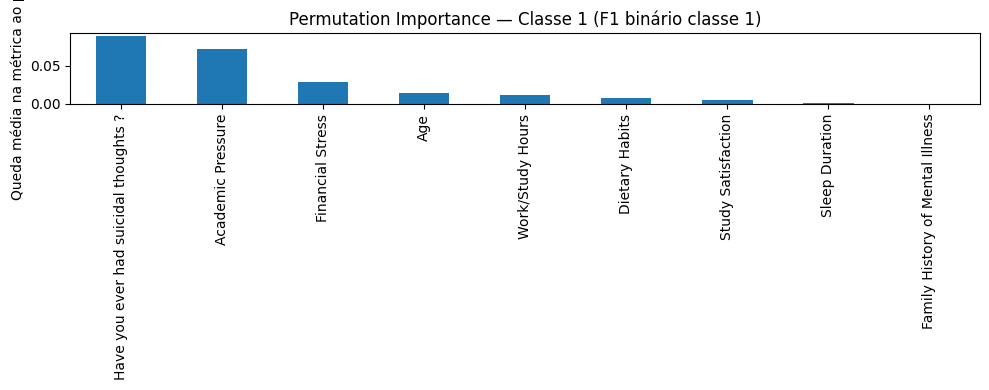


=== Permutation Importance focada na classe 3 (F1-binário) ===


,0
Age,0.00
Academic Pressure,0.00
Study Satisfaction,0.00
Sleep Duration,0.00
Dietary Habits,0.00
Have you ever had suicidal thoughts ?,0.00
Work/Study Hours,0.00
Financial Stress,0.00
Family History of Mental Illness,0.00


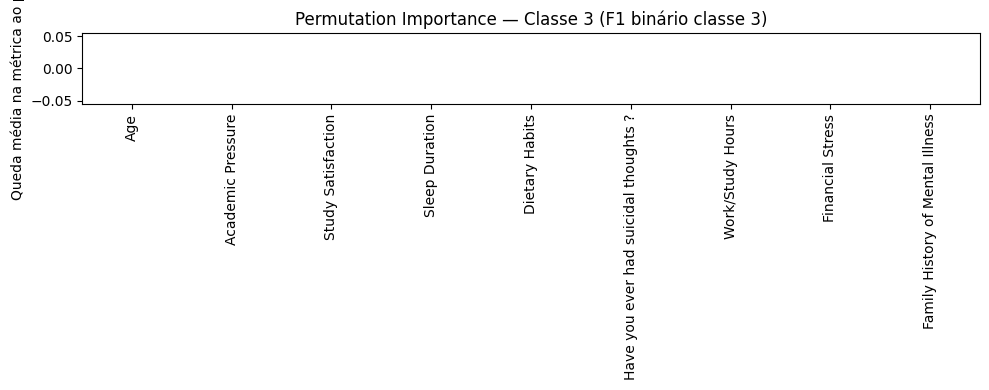


=== Permutation Importance focada na classe 5 (F1-binário) ===


,0
Age,0.00
Academic Pressure,0.00
Study Satisfaction,0.00
Sleep Duration,0.00
Dietary Habits,0.00
Have you ever had suicidal thoughts ?,0.00
Work/Study Hours,0.00
Financial Stress,0.00
Family History of Mental Illness,0.00


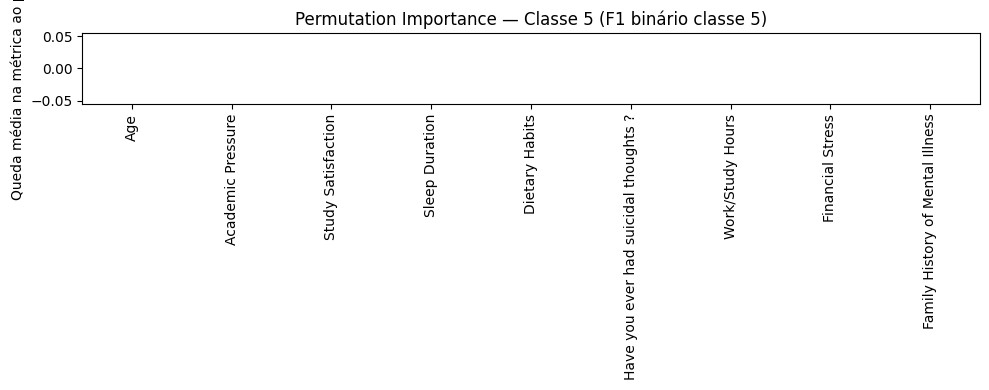

In [108]:
classes = model.classes_
classes_interesse = [1, 3, 5]   # ajuste as classes de interesse

def scorer_para_classe_k_factory(k):
    # k é o rótulo inteiro da classe (ex.: 1, 3, 5)
    def _scorer(estimator, X, y_true_bin):
        # Prediz classe argmax e transforma em binário (1 se ==k, 0 caso contrário)
        y_pred_bin = (estimator.predict(X) == k).astype(int)
        return f1_score(y_true_bin, y_pred_bin, zero_division=0)
    return _scorer

for k in classes_interesse:
    print(f"\n=== Permutation Importance focada na classe {k} (F1-binário) ===")
    y_true_bin = (y_test == k).astype(int)

    result_k = permutation_importance(
        model, X_test, y_true_bin,
        scoring=scorer_para_classe_k_factory(k),
        n_repeats=20, random_state=42, n_jobs=-1
    )

    pi_k = pd.Series(result_k.importances_mean, index=features.columns).sort_values(ascending=False)
    display(pi_k)

    plt.figure(figsize=(10,4))
    pi_k.plot(kind="bar")
    plt.title(f"Permutation Importance — Classe {k} (F1 binário classe {k})")
    plt.ylabel("Queda média na métrica ao permutar")
    plt.tight_layout()
    plt.show()

#Classification Report

Resumo das métricas por classes de modelos de classificação

In [109]:
y_proba = model.predict_proba(X_test)[:, 1]

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0

bal_acc = balanced_accuracy_score(y_test, y_pred)
mcc     = matthews_corrcoef(y_test, y_pred)
kappa   = cohen_kappa_score(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_proba)
ap      = average_precision_score(y_test, y_proba)
ll      = log_loss(y_test, y_proba)
brier   = brier_score_loss(y_test, y_proba)

resumo = pd.Series({
    "Accuracy": acc,
    "Precision (classe 1)": prec,
    "Recall/Sensibilidade (classe 1)": rec,
    "Especificidade (classe 0)": tnr,
    "F1 (classe 1)": f1,
    "Balanced Accuracy": bal_acc,
    "MCC": mcc,
    "Cohen’s Kappa": kappa,
    "ROC AUC": roc_auc,
    "PR AUC (Average Precision)": ap,
    "Log Loss": ll,
    "Brier Score": brier,
    "TP": tp, "FP": fp, "TN": tn, "FN": fn,
    "FPR": fpr, "FNR": fnr
})
print(resumo.round(4))

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=4))

Accuracy                             0.85
Precision (classe 1)                 0.86
Recall/Sensibilidade (classe 1)      0.89
Especificidade (classe 0)            0.79
F1 (classe 1)                        0.87
Balanced Accuracy                    0.84
MCC                                  0.68
Cohen’s Kappa                        0.68
ROC AUC                              0.92
PR AUC (Average Precision)           0.94
Log Loss                             0.36
Brier Score                          0.11
TP                                2902.00
FP                                 488.00
TN                                1825.00
FN                                 365.00
FPR                                  0.21
FNR                                  0.11
dtype: float64

Classification report:

              precision    recall  f1-score   support

           0     0.8333    0.7890    0.8106      2313
           1     0.8560    0.8883    0.8719      3267

    accuracy                         0.8

#Curva Roc
Mede o equilíbrio entre não errar falsos positivos e não perder casos reais de depressão.

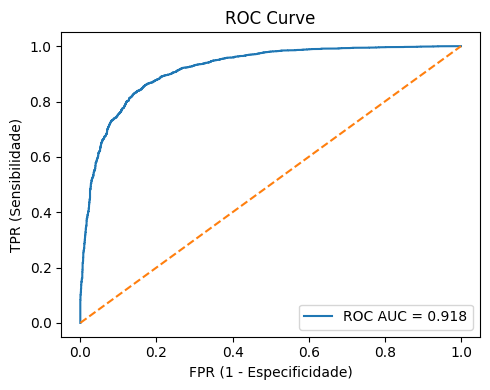

In [110]:
fpr_curve, tpr_curve, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr_curve, tpr_curve, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('FPR (1 - Especificidade)')
plt.ylabel('TPR (Sensibilidade)')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

#Precision-Recall
Se você aumenta recall (pega mais pessoas com depressão), a precision cai (mais falsos alarmes).

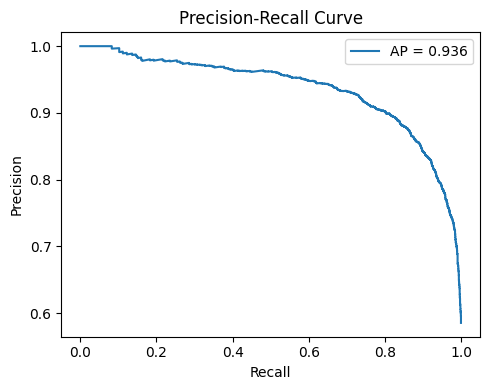

In [111]:
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(rec_curve, prec_curve, label=f'AP = {ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()